In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows',500)

In [144]:
job_clicks=pd.read_csv('job_clicks.csv')
job_clicks.head()

,userId,jobId,Clicks
0,1,31,3
1,1,1029,66
2,1,1061,93
3,1,1129,0
4,1,1172,77


In [145]:
jobs=pd.read_csv('jobs.csv')
jobs.head()

,jobID,job_category
0,1,IT
1,2,IT
2,3,IT
3,4,IT
4,5,IT


In [146]:
job_clicks.shape

(100004, 3)

In [147]:
jobs.shape

(9125, 2)

In [148]:
job=pd.merge(job_clicks,jobs,how='inner',left_on='jobId',right_on='jobID')
job.drop('jobID',1,inplace=True)
job.head()

,userId,jobId,Clicks,job_category
0,1,31,3,Finance
1,7,31,71,Finance
2,31,31,39,Finance
3,32,31,4,Finance
4,36,31,2,Finance


In [149]:
job.isnull().sum()

userId          0
jobId           0
Clicks          0
job_category    0
dtype: int64

In [150]:
job.shape

(100004, 4)

In [151]:
job.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   userId        100004 non-null  int64 
 1   jobId         100004 non-null  int64 
 2   Clicks        100004 non-null  int64 
 3   job_category  100004 non-null  object
dtypes: int64(3), object(1)
memory usage: 3.8+ MB


In [152]:
job.describe()

,userId,jobId,Clicks
count,100004.000000,100004.000000,100004.000000
mean,347.011310,12548.664363,49.884105
std,195.163838,26369.198969,29.141325
min,1.000000,1.000000,0.000000
25%,182.000000,1028.000000,25.000000
50%,367.000000,2406.500000,50.000000
75%,520.000000,5418.000000,75.000000
max,671.000000,163949.000000,100.000000


 * Clicks is the only measure and there seems to be no outlier in the data


### Data Cleaning 

In [153]:
job.job_category.replace('Retial','Retail',inplace=True)

### Analysis

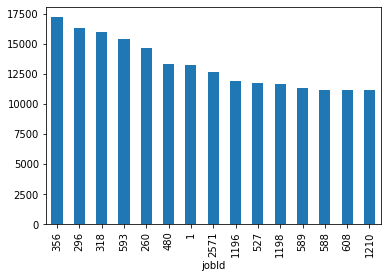

In [154]:
# Top 15 job ids with clicks
job.groupby('jobId')['Clicks'].sum().sort_values(ascending=False)[:15].plot.bar()

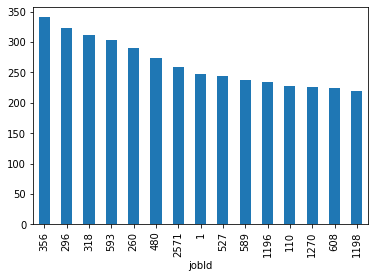

In [155]:
# Top 15 job ids with most views
job.groupby('jobId')['Clicks'].count().sort_values(ascending=False)[:15].plot.bar()

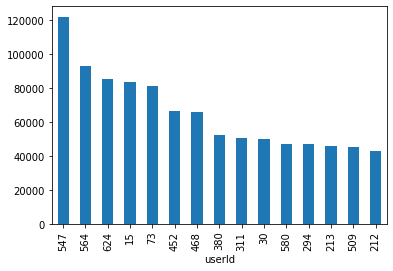

In [156]:
# Top 15 User ids active user ids
job.groupby('userId')['Clicks'].sum().sort_values(ascending=False)[:15].plot.bar()

In [157]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(job, test_size=0.30, random_state=100)

In [158]:
print(train.shape)
print(test.shape)

(70002, 4)
(30002, 4)


In [159]:
# pivot Clicks into job features
df_job_features = train.pivot(
    index='userId',
    columns='jobId',
    values='Clicks'
).fillna(0)

In [160]:
df_job_features.head()

jobId,1,2,3,4,5,6,7,8,9,10,...,160590,160718,161084,161155,161594,161830,161918,161944,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Copy Train and Test Dataset

These dataset will be used for prediction and evaluation.

Dummy train will be used later for prediction of the jobs which has not been clicked by the user. To ignore the jobs rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction.
Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [161]:
dummy_train = train.copy()
dummy_test = test.copy()

In [162]:
print(dummy_train.shape)
dummy_test.shape

(70002, 4)


(30002, 4)

In [163]:
dummy_train['Clicks'] = dummy_train['Clicks'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['Clicks'] = dummy_test['Clicks'].apply(lambda x: 1 if x>=1 else 0)

In [164]:
# The job not clicked by user is marked as 1 for prediction. 
dummy_train = dummy_train.pivot(
    index='userId',
    columns='jobId',
    values='Clicks'
).fillna(1)

# The Job not Clicked by user is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot(
    index='userId',
    columns='jobId',
    values='Clicks'
).fillna(0)

In [165]:
dummy_train.head()

jobId,1,2,3,4,5,6,7,8,9,10,...,160590,160718,161084,161155,161594,161830,161918,161944,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [166]:
dummy_test.head()

jobId,1,2,3,4,5,6,7,8,9,10,...,158238,159690,159755,159858,159972,160438,160440,160656,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# User Similarity Matrix

## Using adjusted Cosine

In [167]:
# Not removing the NaN values and calculating the mean clicks only for the jobs clicked by the user
job_features = train.pivot(
    index='userId',
    columns='jobId',
    values='Clicks'
)

In [168]:
job_features.head()

jobId,1,2,3,4,5,6,7,8,9,10,...,160590,160718,161084,161155,161594,161830,161918,161944,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,95.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Normalising the clicks of the jobs for each user aroung 0 mean

In [169]:
mean=np.nanmean(job_features,axis=1)
df_subtracted=(job_features.T-mean).T

In [170]:
df_subtracted.head()

jobId,1,2,3,4,5,6,7,8,9,10,...,160590,160718,161084,161155,161594,161830,161918,161944,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.127273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.097222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,44.014925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Finding cosine similarity

In [171]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.          0.          0.         ...  0.          0.
  -0.00431598]
 [ 0.          1.          0.03500871 ... -0.03535689  0.00833143
  -0.0321186 ]
 [ 0.          0.03500871  1.         ...  0.07713403 -0.01360546
  -0.07861972]
 ...
 [ 0.         -0.03535689  0.07713403 ...  1.          0.
   0.02193894]
 [ 0.          0.00833143 -0.01360546 ...  0.          1.
   0.07005655]
 [-0.00431598 -0.0321186  -0.07861972 ...  0.02193894  0.07005655
   1.        ]]


# Prediction

* Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [172]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.03500871, ..., 0.        , 0.00833143,
        0.        ],
       [0.        , 0.03500871, 1.        , ..., 0.07713403, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.07713403, ..., 1.        , 0.        ,
        0.02193894],
       [0.        , 0.00833143, 0.        , ..., 0.        , 1.        ,
        0.07005655],
       [0.        , 0.        , 0.        , ..., 0.02193894, 0.07005655,
        1.        ]])

Clicks predicted by the user (for jobs clicked as well as not clicked) is the weighted sum of correlation with the jobs clicked (as present in the job dataset). 

In [173]:
user_predicted_Clicks = np.dot(user_correlation, job_features.fillna(0))
user_predicted_Clicks

array([[3.11733483e+01, 2.57746626e+01, 2.45705458e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.37564436e+02, 7.01964205e+01, 2.72887675e+01, ...,
        0.00000000e+00, 4.15607334e+00, 4.08291414e-03],
       [1.18318269e+02, 3.64078478e+01, 2.13356825e+01, ...,
        1.24523888e+00, 2.88546260e+00, 0.00000000e+00],
       ...,
       [7.17734026e+01, 2.94613255e+01, 1.39073668e+01, ...,
        8.15616515e-01, 3.31434940e-01, 6.99828385e-02],
       [1.58602199e+02, 8.58997199e+01, 4.16242881e+01, ...,
        0.00000000e+00, 1.79389344e+00, 8.00493313e-02],
       [2.55086332e+02, 4.47534638e+01, 1.98789598e+01, ...,
        0.00000000e+00, 3.19394693e+00, 2.54905629e-01]])

In [174]:
user_predicted_Clicks.shape

(671, 8029)

Since we are interested only in the jobs not clicked by the user, we will ignore the jobs clicked by the user by making it zero.

In [175]:
user_final_Clicks = np.multiply(user_predicted_Clicks,dummy_train)
user_final_Clicks.head()

jobId,1,2,3,4,5,6,7,8,9,10,...,160590,160718,161084,161155,161594,161830,161918,161944,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,31.173348,25.774663,24.570546,0.582874,1.588556,15.825699,15.730239,0.434447,7.877187,21.412264,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.397567,0.296227,0.000000,0.000000,0.000000
2,137.564436,70.196421,27.288767,7.267690,36.292110,53.916085,19.352234,0.673023,10.900764,0.000000,...,0.000000,0.000000,0.000000,1.150094,3.689575,0.000000,0.000000,0.000000,4.156073,0.004083
3,118.318269,36.407848,21.335682,9.474523,22.134860,38.756035,11.035872,0.489486,12.776078,49.271249,...,1.242540,0.000000,0.000000,3.554033,2.561584,1.634766,1.218061,1.245239,2.885463,0.000000
4,116.311201,49.794210,19.991473,6.340032,28.347859,43.777373,16.386743,2.384774,16.835784,0.000000,...,0.000000,0.028315,0.102474,0.000000,0.000000,2.031559,1.513710,0.000000,0.000000,0.209456
5,105.863013,37.518957,0.000000,9.826665,23.831269,47.032202,26.611609,1.161516,6.026965,58.046338,...,1.365149,0.000000,0.000000,0.000000,1.027884,0.555009,0.413536,0.000000,1.157846,0.113945


## Finding the top 5 recommendation for user 1

In [176]:
user_final_Clicks.iloc[1].sort_values(ascending=False)[0:5]

jobId
318    191.586991
595    141.031335
527    139.502729
380    139.453025
780    137.948823
Name: 2, dtype: float64

# Item based similarity

Taking the transpose of the Clicks matrix to normalize the clicks for different jobId. In the user based similarity, we had taken clicks for each user intead of each jobId.

In [177]:
job_features = train.pivot(
    index='userId',
    columns='jobId',
    values='Clicks'
).T
job_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
jobId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,87.0,NaN,81.0,NaN,...,NaN,18.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,71.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,95.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
# Normalizing the clicks for each job id
mean = np.nanmean(job_features, axis=1)
df_subtracted = (job_features.T-mean).T

In [179]:
df_subtracted.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
jobId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,32.953488,NaN,26.953488,NaN,...,NaN,-36.046512,-47.046512,NaN,NaN,NaN,NaN,NaN,NaN,16.953488
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-48.407895,NaN,NaN,-4.407895,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,38.702703,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-16.297297,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-47.818182,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.         -0.0727384  -0.06442378 ...  0.          0.
   0.        ]
 [-0.0727384   1.         -0.03527023 ...  0.          0.
   0.        ]
 [-0.06442378 -0.03527023  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [181]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Prediction

In [182]:
item_predicted_Clicks = np.dot((job_features.fillna(0).T),item_correlation)
item_predicted_Clicks

array([[  5.05571338,  15.64692397,  13.72769373, ...,   0.        ,
          0.        ,   0.        ],
       [ 53.03680891,  54.43969323,  58.20879066, ...,   0.        ,
          0.        ,   0.        ],
       [ 28.97758423,  38.89789202,  38.52493511, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 29.1747194 ,  23.72738453,   3.76213665, ...,   0.        ,
          0.        ,   0.        ],
       [ 19.75889642,  23.5096601 ,  17.96222134, ...,   0.        ,
          0.        ,   0.        ],
       [173.94945637,  72.8109069 ,  94.60717701, ...,   0.        ,
          0.        ,   0.        ]])

In [183]:
item_predicted_Clicks.shape

(671, 8029)

In [184]:
dummy_train.shape

(671, 8029)

## Filtering the Clicks only for the jobs not clicked by the user for recommendation

In [185]:
item_final_Clicks = np.multiply(item_predicted_Clicks,dummy_train)
item_final_Clicks.head()

jobId,1,2,3,4,5,6,7,8,9,10,...,160590,160718,161084,161155,161594,161830,161918,161944,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,5.055713,15.646924,13.727694,4.031734,4.572963,15.061586,6.779620,0.943018,14.817761,14.414222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53.036809,54.439693,58.208791,42.514627,59.911518,82.367772,56.456260,73.490822,51.497328,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28.977584,38.897892,38.524935,23.027439,29.417905,28.496542,16.433572,14.017592,18.078692,33.766745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,114.110781,165.689364,215.312292,76.389033,112.966039,143.494195,133.844416,51.287773,143.810507,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,64.193816,115.867827,0.000000,40.470793,79.117972,64.111874,75.343006,29.465119,22.901381,75.991316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
# Top 5 predictions for user 1
item_final_Clicks.iloc[1].sort_values(ascending=False)[0:5]

jobId
38886    170.253328
1529     166.170538
3577     164.283347
3015     164.245241
803      163.621355
Name: 2, dtype: float64

# Evaluation

# Using user similararity

In [187]:
test_job_features = test.pivot(
    index='userId',
    columns='jobId',
    values='Clicks'
)
mean = np.nanmean(test_job_features, axis=1)
test_df_subtracted = (test_job_features.T-mean).T

# User Similarity Matrix
test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[ 1.          0.          0.         ...  0.04971613  0.
   0.        ]
 [ 0.          1.          0.02613255 ...  0.         -0.05517181
   0.        ]
 [ 0.          0.02613255  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.04971613  0.          0.         ...  1.          0.
   0.        ]
 [ 0.         -0.05517181  0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [188]:
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_Clicks = np.dot(test_user_correlation, test_job_features.fillna(0))
test_user_predicted_Clicks

array([[1.33808582e+01, 5.36248541e+00, 8.74684565e+00, ...,
        1.06924012e-01, 0.00000000e+00, 4.27696046e-01],
       [4.23655444e+01, 2.23199140e+01, 5.69205083e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.30740674e+01, 6.53340152e+00, 7.38603108e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.33907161e+00, 7.87491622e+00, 6.90779626e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.38224269e+02, 5.19268194e+00, 4.22525814e+00, ...,
        2.80475882e-01, 0.00000000e+00, 1.12190353e+00],
       [3.89539053e+01, 1.00547182e+01, 2.40034084e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## Doing predictions for jobs clicked by the user

In [189]:
test_user_final_click = np.multiply(test_user_predicted_Clicks,dummy_test)

In [190]:
test_user_final_click.head()

jobId,1,2,3,4,5,6,7,8,9,10,...,158238,159690,159755,159858,159972,160438,160440,160656,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating the RMSE for only the jobs clicked by user. For RMSE, normalising the Clicks to (1,100) range.

In [191]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_click.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 100))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


MinMaxScaler(copy=True, feature_range=(1, 100))
[[        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [36.75832912         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]


In [192]:
test_ = test.pivot(
    index='userId',
    columns='jobId',
    values='Clicks'
)

In [193]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [194]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

23.8598811582639


In [195]:
test_job_features = test.pivot(
    index='userId',
    columns='jobId',
    values='Clicks'
).T

mean = np.nanmean(test_job_features, axis=1)
test_df_subtracted = (test_job_features.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation<0]=0

In [196]:
test_item_correlation.shape

(5776, 5776)

In [197]:
test_job_features.shape

(5776, 671)

In [198]:
test_item_predicted_Clicks = (np.dot(test_item_correlation, test_job_features.fillna(0))).T
test_item_final_Clicks = np.multiply(test_item_predicted_Clicks,dummy_test)
test_item_final_Clicks.head()

jobId,1,2,3,4,5,6,7,8,9,10,...,158238,159690,159755,159858,159972,160438,160440,160656,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
test_ = test.pivot(
    index='userId',
    columns='jobId',
    values='Clicks'
)

In [200]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_item_final_Clicks.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 100))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot(
    index='userId',
    columns='jobId',
    values='Clicks'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


MinMaxScaler(copy=True, feature_range=(1, 100))


In [201]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

40.62869656355364


In [202]:
item_final_Clicks.iloc[1].sort_values(ascending=False)[0:5]

jobId
38886    170.253328
1529     166.170538
3577     164.283347
3015     164.245241
803      163.621355
Name: 2, dtype: float64

In [203]:
user_final_Clicks.iloc[101].sort_values(ascending=False)[0:5]

jobId
356     115.914115
593      91.400414
1198     85.504776
296      77.581830
110      72.732938
Name: 102, dtype: float64

In [204]:
job[job['userId']==101]

,userId,jobId,Clicks,job_category
5302,101,370,86,IT
5848,101,457,24,Finance
6931,101,527,37,HR
7962,101,589,44,HR
9144,101,318,19,HR
10122,101,1210,78,Management
10845,101,2028,89,IT
11119,101,2716,86,Retail
12346,101,7153,35,HR
12838,101,58559,73,Banking


In [205]:
job[job['jobId']==356]

,userId,jobId,Clicks,job_category
4476,2,356,55,IT
4477,3,356,43,IT
4478,4,356,33,IT
4479,5,356,36,IT
4480,7,356,25,IT
4481,8,356,4,IT
4482,13,356,75,IT
4483,15,356,93,IT
4484,17,356,68,IT
4485,19,356,71,IT


In [206]:
# Considering the comparatively lower RMSE of the user Similarity, this model should be adopted
# Verified based on user ids for predicted job roles and compared with the job categories of the clicked job roles.
user_final_Clicks

jobId,1,2,3,4,5,6,7,8,9,10,...,160590,160718,161084,161155,161594,161830,161918,161944,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,31.173348,25.774663,24.570546,0.582874,1.588556,15.825699,15.730239,0.434447,7.877187,21.412264,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.397567,0.296227,0.000000,0.000000,0.000000
2,137.564436,70.196421,27.288767,7.267690,36.292110,53.916085,19.352234,0.673023,10.900764,0.000000,...,0.000000,0.000000,0.000000,1.150094,3.689575,0.000000,0.000000,0.000000,4.156073,0.004083
3,118.318269,36.407848,21.335682,9.474523,22.134860,38.756035,11.035872,0.489486,12.776078,49.271249,...,1.242540,0.000000,0.000000,3.554033,2.561584,1.634766,1.218061,1.245239,2.885463,0.000000
4,116.311201,49.794210,19.991473,6.340032,28.347859,43.777373,16.386743,2.384774,16.835784,0.000000,...,0.000000,0.028315,0.102474,0.000000,0.000000,2.031559,1.513710,0.000000,0.000000,0.209456
5,105.863013,37.518957,0.000000,9.826665,23.831269,47.032202,26.611609,1.161516,6.026965,58.046338,...,1.365149,0.000000,0.000000,0.000000,1.027884,0.555009,0.413536,0.000000,1.157846,0.113945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,120.161529,51.793224,21.614747,5.707491,36.203554,0.000000,20.340620,1.217437,19.728043,77.623064,...,0.927374,0.223160,0.807628,0.260940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
668,120.054280,41.809231,18.585715,6.113038,19.261137,31.162100,9.493495,2.456975,0.819363,53.050217,...,0.000000,0.449044,1.625112,0.299581,2.116436,0.325809,0.242760,0.000000,2.384032,0.000000
669,71.773403,29.461325,13.907367,5.578807,12.535938,14.957613,14.712261,0.045186,7.127839,42.868714,...,0.000000,0.000000,0.000000,1.789404,0.294233,0.196186,0.146178,0.815617,0.331435,0.069983


In [250]:
job_recommender=pd.DataFrame(columns=['userId',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
job_recommender.userId=user_final_Clicks.index
#job_recommender.set_index('userId',inplace=True)
#job_recommender=job_recommender.transpose()

In [251]:
job_recommender

,userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
job_recommender.shape

(671, 15)

In [ ]:
for row in range(1,672):
    for col in range(1,16):
        job_recommender.loc[col,row]=np.array(user_final_Clicks.iloc[row].sort_values(ascending=False)[0:15].index)[col-1]

In [ ]:
job_recommender

In [245]:
user_final_Clicks.iloc[1].sort_values(ascending=False)[0:15]

jobId
318     191.586991
595     141.031335
527     139.502729
380     139.453025
780     137.948823
1       137.564436
260     126.127574
47      122.988160
1036    121.079168
50      119.963937
1580    117.901274
648     115.361194
1210    114.617072
344     113.641302
736     107.041828
Name: 2, dtype: float64

In [244]:
job_recommender[1]

1      595
2      527
3      380
4      780
5        1
6      260
7       47
8     1036
9       50
10    1580
11     648
12    1210
13     344
14     736
15     NaN
0      318
Name: 1, dtype: object